### 異常値を取り除かなあかん　2021/0711/22:01

In [24]:

import numpy as np
import pandas as pd
from pandas import DataFrame  as DF
import matplotlib.pyplot as plt
import seaborn as sns
import math


from scipy import stats

%matplotlib inline

# matplotlibを日本語表示に対応させるモジュール
# !pip install japanize-matplotlib
# import japanize_matplotlib

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.model_selection import KFold
from functools import partial
import optuna
from xfeat import SelectCategorical, LabelEncoder, Pipeline,ConcatCombination, SelectNumerical,ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [3]:
df = pd.read_csv("input/OnlineNewsPopularity.csv")
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8,11,346,0.529052,1.0,0.684783,9,7,1,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8,12,328,0.696296,1.0,0.885057,9,7,3,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8,10,442,0.516355,1.0,0.644128,24,1,12,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8,6,682,0.539493,1.0,0.692661,10,1,1,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


In [3]:
#列名取得
col_lst = df.columns
# col_lst

In [4]:
#欠損値チェック

check_null = df.isnull().any().values.tolist()
check_null = [[col_lst[i],check_null[i]] for i in range(len(col_lst))]
check_null

[['url', False],
 ['timedelta', False],
 ['n_tokens_title', False],
 ['n_tokens_content', False],
 ['n_unique_tokens', False],
 ['n_non_stop_words', False],
 ['n_non_stop_unique_tokens', False],
 ['num_hrefs', False],
 ['num_self_hrefs', False],
 ['num_imgs', False],
 ['num_videos', False],
 ['average_token_length', False],
 ['num_keywords', False],
 ['data_channel_is_lifestyle', False],
 ['data_channel_is_entertainment', False],
 ['data_channel_is_bus', False],
 ['data_channel_is_socmed', False],
 ['data_channel_is_tech', False],
 ['data_channel_is_world', False],
 ['kw_min_min', False],
 ['kw_max_min', False],
 ['kw_avg_min', False],
 ['kw_min_max', False],
 ['kw_max_max', False],
 ['kw_avg_max', False],
 ['kw_min_avg', False],
 ['kw_max_avg', False],
 ['kw_avg_avg', False],
 ['self_reference_min_shares', False],
 ['self_reference_max_shares', False],
 ['self_reference_avg_sharess', False],
 ['weekday_is_monday', False],
 ['weekday_is_tuesday', False],
 ['weekday_is_wednesday', False

In [4]:
#列ごとに統計量をチェック

n = 9
# print(df[col_lst[n]].describe())
print(df["shares"].describe())


count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


In [5]:
coef_map_df = df.loc[:, "n_tokens_title":]
target_df = df["shares"]
data_df = df.loc[0:, "n_tokens_title":"abs_title_sentiment_polarity"]

C:\Users\kyotn\anaconda3\envs\data-science\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

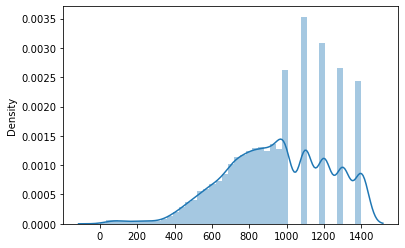

In [6]:
# y = target_df.values
y = target_df[target_df <= 1400 ].values
sns.distplot(y)

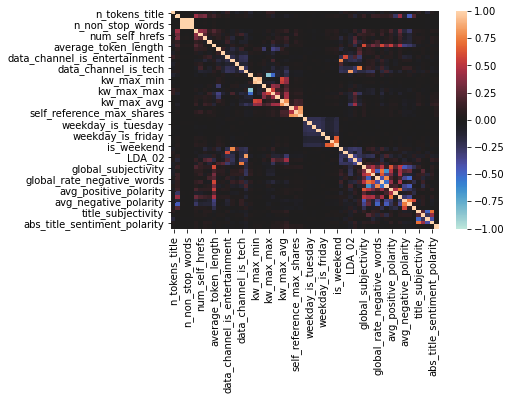

In [26]:
sns.heatmap(coef_map_df.corr(), vmax=1, vmin=-1, center=0)
corr_df = coef_map_df.corr()
corr_df.to_clipboard()


In [24]:
coef_map_df

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


In [7]:
# dlth = data less&equal than half
# dmth = data more than half

dlth = coef_map_df[coef_map_df["shares"] <= 1400]
dmth = coef_map_df[coef_map_df["shares"] > 1400]

# dlt75 = data less&equal than 75%, more than 50%
# dmt75 = data more than 75%

dlt75 = dmth[dmth["shares"] <= 2800]
dmt75 = dmth[dmth["shares"] > 2800]

print(len(dlth)+len(dmth))

39644


 ### 25、50、75％で分割して2値分類の形にしてみる (test1) 

In [8]:
# t1d = test1_data
# tl = target_list
#25, 50, 75 =  946, 140, 2800
t1d = coef_map_df.copy()
tl = []
for i in range(len(t1d)):
    if t1d.loc[i, "shares"] <= 1400:
        tl.append(0)

    if t1d.loc[i, "shares"] > 1400:
        tl.append(1)

t1d["target"] = tl

In [8]:
# corr_df = t1d.corr()
# corr_df.to_clipboard()
t1d

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,target
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,1
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,1
39640,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,1
39641,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900,1
39642,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100,0


In [9]:
_input = t1d.drop("shares", axis=1)
_input

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,target
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1
39640,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1
39641,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1
39642,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,0


### LightGBMで変数選択

In [70]:
# LightGBMのパラメータを設定する
lgbm_params = {
    "objective": "binary",
    "metric": "binary_error",
}
fit_kwargs = {
    "num_boost_round": 10,
}

# 特徴量選択器を作成する
selector = GBDTFeatureSelector(
    target_col="target",
    threshold=0.5,
    lgbm_params=lgbm_params,
    lgbm_fit_kwargs=fit_kwargs,
)

selected_df = selector.fit_transform(_input)
print("Selected columns:", selector._selected_cols)

[LightGBM] [Info] Number of positive: 19562, number of negative: 20082
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8258
[LightGBM] [Info] Number of data points in the train set: 39644, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493442 -> initscore=-0.026235
[LightGBM] [Info] Start training from score -0.026235
Selected columns: ['is_weekend', 'self_reference_min_shares', 'kw_avg_avg', 'kw_max_avg', 'LDA_00', 'data_channel_is_socmed', 'kw_min_avg', 'n_unique_tokens', 'data_channel_is_entertainment', 'data_channel_is_tech', 'kw_avg_min', 'n_non_stop_unique_tokens', 'kw_max_max', 'n_tokens_content', 'self_reference_avg_sharess', 'LDA_02', 'min_positive_polarity', 'num_imgs', 'LDA_01', 'kw_min_max', 'kw_avg_max', 'num_hrefs', 'LDA_04', 'global_subjectivity', 'self_reference_max_shares', 'num_self_hrefs', 'nu

In [ ]:
import lightgbm as lgb

LGBM_PARAMS = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
}


def objective(df, selector, trial):
    selector.set_trial(trial)
    selector.fit(df)
    input_cols = selector.get_selected_cols()

    # Hyper Parameter Tuning するパラメータと範囲を設定する
    lgbm_params = {
        'num_leaves': trial.suggest_int("num_leaves", 3, 20),
        'max_depth': trial.suggest_int("max_depth", 3, 20),
    }
    lgbm_params.update(LGBM_PARAMS)

    # Evaluate with selected columns
    train_set = lgb.Dataset(_input[input_cols], label=_input["target"])
    scores = lgb.cv(lgbm_params, train_set, num_boost_round=100, stratified=False, seed=1)
    
    binary_error_score = scores['binary_error-mean'][-1]
    return 1 - binary_error_score


# 特徴量探索のための説明変数を設定する
# encoded_train_df は、No.7で作成したDataFrameと同じ
input_cols = list(_input.columns)
input_cols.remove('target')


# 特徴量探索器を作成する
selector = GBDTFeatureExplorer(
    input_cols=input_cols,
    target_col="target",
    fit_once=True,
    threshold_range=(0.2, 0.5),
    lgbm_params=LGBM_PARAMS,
)

# Hyper Parameter Tuning を行う
study = optuna.create_study(direction="minimize")
study.optimize(partial(objective, _input, selector), n_trials=100)

# 選択された特徴量を確認する
selector.from_trial(study.best_trial)
print("Selected columns:", selector.get_selected_cols())

 imprtant_variable? :
 Selected columns: ['LDA_00', 'kw_avg_avg', 'LDA_02', 'kw_max_avg', 'n_unique_tokens',
                    'self_reference_min_shares', 'n_tokens_content', 'n_non_stop_unique_tokens',
                    'kw_avg_min', 'kw_avg_max', 'LDA_03', 'average_token_length', 'LDA_01']

In [36]:
# imp_data = important_data

imp_data = t1d[['LDA_00', 'kw_avg_avg', 'LDA_02', 'kw_max_avg', 'n_unique_tokens',
                    'self_reference_min_shares', 'n_tokens_content', 'n_non_stop_unique_tokens',
                    'kw_avg_min', 'kw_avg_max', 'LDA_03', 'average_token_length', 'LDA_01', 'target']]
imp_data

,LDA_00,kw_avg_avg,LDA_02,kw_max_avg,n_unique_tokens,self_reference_min_shares,n_tokens_content,n_non_stop_unique_tokens,kw_avg_min,kw_avg_max,LDA_03,average_token_length,LDA_01,target
0,0.500331,0.000000,0.040005,0.000000,0.663594,496.0,219,0.815385,0.000,0.0000,0.041263,4.680365,0.378279,0
1,0.799756,0.000000,0.050096,0.000000,0.604743,0.0,255,0.791946,0.000,0.0000,0.050101,4.913725,0.050047,0
2,0.217792,0.000000,0.033351,0.000000,0.575130,918.0,211,0.663866,0.000,0.0000,0.033334,4.393365,0.033334,1
3,0.028573,0.000000,0.494651,0.000000,0.503788,0.0,531,0.665635,0.000,0.0000,0.028905,4.404896,0.419300,0
4,0.028633,0.000000,0.028575,0.000000,0.415646,545.0,1072,0.540890,0.000,0.0000,0.028572,4.682836,0.028794,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,0.025038,3031.115764,0.151701,4004.342857,0.529052,11400.0,346,0.684783,173.125,374962.5000,0.025000,4.523121,0.025001,1
39640,0.029349,3411.660830,0.231866,5470.168651,0.696296,2100.0,328,0.885057,184.000,192985.7143,0.681635,4.405488,0.028575,1
39641,0.159004,4206.439195,0.025207,6880.687034,0.516355,1400.0,442,0.644128,168.250,295850.0000,0.643794,5.076923,0.025025,1
39642,0.040004,1777.895883,0.839987,3384.316871,0.539493,452.0,682,0.692661,-1.000,254600.0000,0.040002,4.975073,0.040003,0


In [68]:
idt0.to_clipboard()

In [19]:
# idt0 = imp_data_target_0
# idt1 = imp_data_target_1

idt0 = imp_data[imp_data["target"] == 0 ]
idt1 = imp_data[imp_data["target"] == 1 ]

col_lst = imp_data.columns

In [147]:
print(df["n_non_stop_unique_tokens"].describe())

count    39644.000000
mean         0.689175
std          3.264816
min          0.000000
25%          0.625739
50%          0.690476
75%          0.754630
max        650.000000
Name: n_non_stop_unique_tokens, dtype: float64


column: n_non_stop_unique_tokens


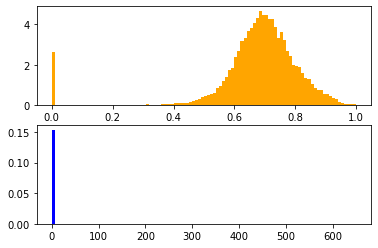

In [146]:
ipt_dt = [idt0,idt1]
# ipt_dt = [dlt75,dmt75]
n = 7


# fig , ax = plt.subplots(2,1, sharex=True)
fig , ax = plt.subplots(2,1)


for tar_cls, i in zip(ipt_dt, [0,1]):
    """
    st_temp = pd.DataFrame(tar_cls[col_lst[n]].describe())
    st_lst =[]
    st_lst.append(st_temp.loc["mean", col_lst[n]])
    st_lst.append(st_temp.loc["std", col_lst[n]])
    """
    X =np.array(tar_cls[col_lst[n]])
    # norm_pdf = stats.norm.pdf(x=X, loc=st_lst[0], scale=st_lst[1]) # 期待値=st0, 標準偏差=st1
    
    
    if i == 0:
        # plt.plot(X, norm_pdf, color="orange")
        ax[0].hist(X, bins=100, color="orange", density=True)
    else:
        # plt.plot(X, norm_pdf, color="blue")
        ax[1].hist(X, bins=100, color="blue", density=True)

    # plt.xlabel("確率変数X", fontsize=13)
    # plt.ylabel("確率密度pdf", fontsize=13)
print(f"column: {col_lst[n]}")
plt.show()

In [ ]:
n =1

x = np.hstack([ np.c_[np.array(idt0[col_lst[n]])], np.c_[np.array(idt1[col_lst[n]])] ])
colors = ["orange", "blue"]

labels = ["0", "1"]
bins = 100
plt.hist(x, bins, density=True, color=colors, label=labels)

print(f"column: {col_lst[n]}")
plt.show()

In [34]:
st_temp = pd.DataFrame(idt1[col_lst[0]].describe())
st_temp.loc["mean", col_lst[0]]
# st_temp

0.20186977705485123

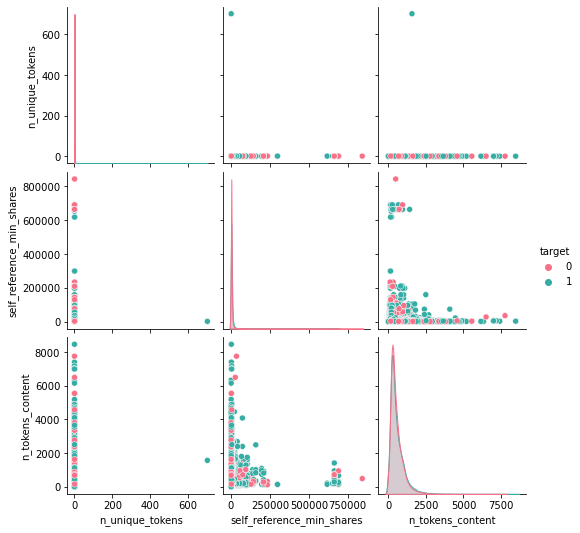

In [16]:
# iris_dataset = sns.load_dataset("iris")

imp_data1 = imp_data[['n_unique_tokens',
                    'self_reference_min_shares', 'n_tokens_content', 'target']]

sns.pairplot(imp_data1, hue='target', palette="husl")
plt.show()
# .savefig('seaborn_iris.png')

In [ ]:
gr = pd.plotting.scatter_matrix(imp_data, c=iris_datalabel, figsize=(8,8), marker = 'o', hist_kwds = {'bins':20}, s=60, alpha=.8, cmap = mglearn.cm3)
plt.show()

In [11]:
lst = []
for i in range(len(df)):
    if df.loc[i, " weekday_is_monday"]:
        lst.append(0)

    if df.loc[i, " weekday_is_tuesday"]:
        lst.append(1)

    if df.loc[i, " weekday_is_wednesday"]:
        lst.append(2)

    if df.loc[i, " weekday_is_thursday"]:
        lst.append(3)

    if df.loc[i, " weekday_is_friday"]:
        lst.append(4)

    if df.loc[i, " weekday_is_saturday"]:
        lst.append(5)

    if df.loc[i, " weekday_is_sunday"]:
        lst.append(6)

df["weekday"] = lst

       


In [14]:
pt_temp = pd.pivot_table(df, index=df["weekday"], columns=df[" shares"],
                             values=" shares", aggfunc="count")

In [21]:
out = pt_temp.fillna(0)


In [24]:
out.to_csv("pivot.csv")

In [22]:
out

shares,1,4,5,8,22,23,28,35,36,41,...,284700,298400,306100,310800,441000,617900,652900,663600,690400,843300
weekday,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
